# utterance, output 속의 name1과 name2 특성 EDA

In [140]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
def make_dataframe(path: str) -> pd.DataFrame:
    """
    Read a json file and return a pandas DataFrame.

    Parameters:
    path (str): Path to the json file.

    Returns:
    pd.DataFrame: DataFrame of the json file.
    """
    # Read the json file
    with open(path, 'r') as file:
        data = json.load(file)

    # Create a DataFrame
    # columns = ['id', 'conversation', 'subject_keyword', 'output']
    df = pd.DataFrame(data)
    df['conversation'] = df['input'].apply(lambda x: x['conversation'])
    df['subject_keyword'] = df['input'].apply(lambda x: x['subject_keyword'])

    # Drop the 'input' column
    df.drop('input', axis=1, inplace=True)

    # Speakers in the conversation
    df['speakers'] = df['conversation'].apply(lambda turns: list(set(turn['speaker'] for turn in turns)))

    # Reorder the columns
    df = df[['id', 'conversation', 'subject_keyword', 'speakers', 'output']]

    return df

In [3]:
train_df = make_dataframe('../resource/data/일상대화요약_train.json')
dev_df = make_dataframe('../resource/data/일상대화요약_dev.json')
test_df = make_dataframe('../resource/data/일상대화요약_test.json')

In [27]:
train_df.head(1)

,id,conversation,subject_keyword,speakers,output
0,nikluge-2024-일상 대화 요약-train-000001,"[{'speaker': 'SD2000001', 'utterance': '저는 여행 ...",[해외여행],"[SD2000001, SD2000002]",이 대화에서 화자들은 좋았던 여행지와 기억나는 주요 명소에 대해 이야기했습니다. S...


In [205]:
result_df = make_dataframe('../results/내가내가.json')

In [209]:
result2_df = make_dataframe('../results/hyperstella.json')
result3_df = make_dataframe('../results/hyperstellar2.json')

In [199]:
def name_token_analysis(df: pd.DataFrame, test=None) -> None:
    """
    Analyze the number of tokens in the names of the speakers.

    Parameters:
    df (pd.DataFrame): DataFrame of the json file.
    """

    df = deepcopy(df)

    name_types = [
                ' name ',
                # train
                'name가',
                'name너',
                'name누나가',
                'name는',
                'name님',
                'name님은',
                'name님의',
                'name님이',
                'name도',
                'name라는',
                'name랑',
                'name밖에',
                'name아',
                'name에',
                'name이',
                'name이.',
                'name이가',
                'name이고',
                'name이는',
                'name이도',
                'name이랑',
                'name이랑.',
                'name이랑도',
                'name이한테',
                # dev
                'name에게',
                'name의',] 

    # The number of samples that have 'name' token in the utterance
    have_name_tokens = df['conversation'].apply(lambda turns: any('name' in turn['utterance'] for turn in turns))
    print(f"The number of samples that have 'name' token: {have_name_tokens.sum()}",'/',
          f"{len(df)}")
    
    # Samples that name+int token is in the utterance
    name_int_tokens = df['conversation'].apply(lambda turns: any(re.search(r' name\d+', turn['utterance']) for turn in turns))
    print(f"The number of samples that have 'name+int' token in the utterance : {name_int_tokens.sum()}",'/',
          f"{len(df)}")
    
    # Samples that only name token is in the utterance
    only_name_tokens = df['conversation'].apply(lambda turns: any(any(name_type in turn['utterance'] for name_type in name_types) for turn in turns))
    print(f"The number of samples that have only 'name' token in the utterance : {only_name_tokens.sum()}",'/',
          f"{len(df)}")
    
    #### name과 name+int token이 동시에 있는 경우가 3개 존재!! ####


    # The number of samples that have 'name' token in the output
    if not test:
        have_name_tokens_output = df['output'].apply(lambda x: 'name' in x)
        print(f"The number of samples that have 'name' token in the output: {have_name_tokens_output.sum()}",'/',
            f"{len(df)}")
        
        # print(have_name_tokens_output.index[have_name_tokens_output == True])

        # The number of samples that have 'name' token in the utterance and the output 
        have_name_tokens_both = df.apply(lambda x: any('name' in turn['utterance'] for turn in x['conversation']) and 'name' in x['output'], axis=1)
        print(f"The number of samples that have 'name' token in the utterance and the output: {have_name_tokens_both.sum()}",'/',
            f"{len(df)}")
        
        # print(df[have_name_tokens][have_name_tokens_both == False].index)
        
    print('-'*50)

    # Visualize the correlation between sample's total utterance that have 'name' token in the utterance and the output at the same time and the sample's total utterance length that have 'name' token
    if not test:
        pure_name_tokens = name_int_tokens | only_name_tokens
        pure_df = df[have_name_tokens] # df[pure_name_tokens]

        # total utterance length that have 'name' token
        pure_df['total_utterance_length'] = pure_df['conversation'].apply(lambda turns: sum(len(turn['utterance']) for turn in turns))

        # Samples that have 'name' token in the utterance and the output at the same time
        pure_df['have_name_tokens_both'] = pure_df.apply(lambda x: any('name' in turn['utterance'] for turn in x['conversation']) and 'name' in x['output'], axis=1)
        print(f"The number of samples that have 'name' token in the utterance and the output at the same time: {pure_df['have_name_tokens_both'].sum()}",'/',
            f"{len(pure_df)}")

        # Samples that have 'name' token in the utterance but not in the output
        pure_df['have_name_tokens_not_output'] = pure_df.apply(lambda x: any('name' in turn['utterance'] for turn in x['conversation']) and 'name' not in x['output'], axis=1)
        print(f"The number of samples that have 'name' token in the utterance but not in the output: {pure_df['have_name_tokens_not_output'].sum()}",'/',
            f"{len(pure_df)}")

        # Visualize the correlation between sample's total utterance that have 'name' token in the utterance and the output at the same time and the sample's total utterance length that have 'name' token
        plt.figure(figsize=(10, 5))
        ax = sns.scatterplot(data=pure_df, x='total_utterance_length', y='have_name_tokens_both', hue='have_name_tokens_both')

        # Find min and max and add the text to the plot
        min_length = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].min()
        max_length = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].max()
        min_index = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].idxmin()
        max_index = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].idxmax()

        ax.annotate(f"min: {min_length}", (min_length, 1), textcoords="offset points", xytext=(0,-100), arrowprops=dict(facecolor='black', shrink=0.01), color='r')
        ax.annotate(f"max: {max_length}", (max_length, 1), textcoords="offset points", xytext=(0,-100), arrowprops=dict(facecolor='black', shrink=0.01), color='r')

        plt.title("The correlation between sample's total utterance length that have 'name' token and the output at the same time")
        plt.legend()
        plt.show()

The number of samples that have 'name' token: 193 / 506
The number of samples that have 'name+int' token in the utterance : 112 / 506
The number of samples that have only 'name' token in the utterance : 61 / 506
The number of samples that have 'name' token in the output: 13 / 506
The number of samples that have 'name' token in the utterance and the output: 13 / 506
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 11 / 170
The number of samples that have 'name' token in the utterance but not in the output: 159 / 170


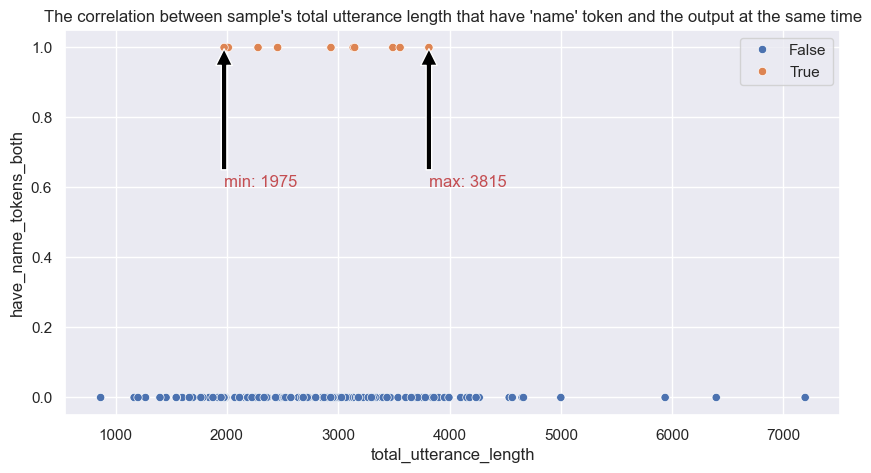

In [197]:
name_token_analysis(train_df)

The number of samples that have 'name' token: 193 / 506
The number of samples that have 'name+int' token in the utterance : 112 / 506
The number of samples that have only 'name' token in the utterance : 61 / 506
The number of samples that have 'name' token in the output: 13 / 506
The number of samples that have 'name' token in the utterance and the output: 13 / 506
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 13 / 193
The number of samples that have 'name' token in the utterance but not in the output: 180 / 193


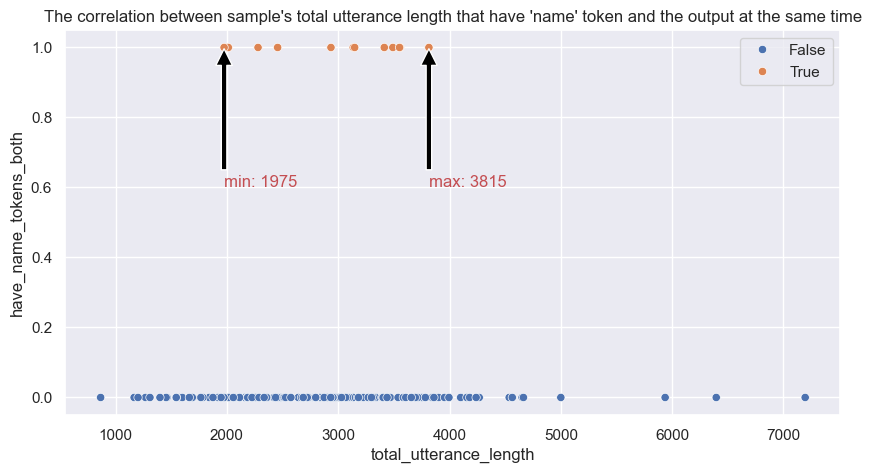

In [200]:
name_token_analysis(train_df)

The number of samples that have 'name' token: 36 / 102
The number of samples that have 'name+int' token in the utterance : 24 / 102
The number of samples that have only 'name' token in the utterance : 9 / 102
The number of samples that have 'name' token in the output: 4 / 102
The number of samples that have 'name' token in the utterance and the output: 4 / 102
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 4 / 33
The number of samples that have 'name' token in the utterance but not in the output: 29 / 33


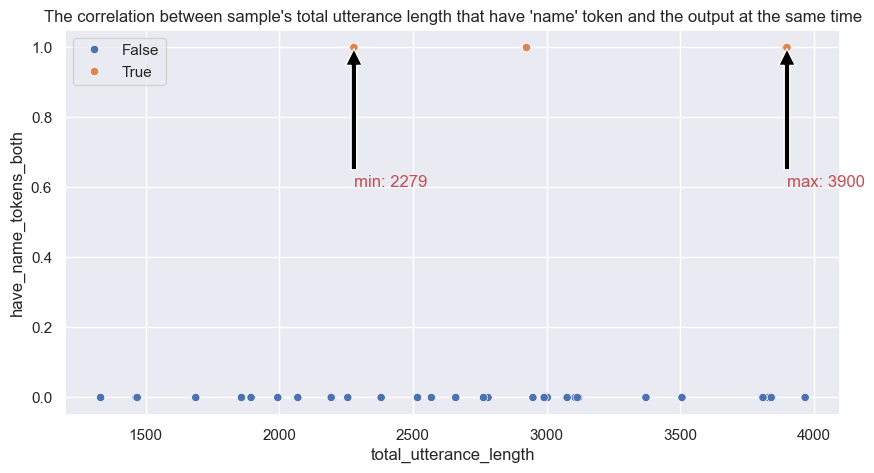

In [198]:
name_token_analysis(dev_df)

The number of samples that have 'name' token: 36 / 102
The number of samples that have 'name+int' token in the utterance : 24 / 102
The number of samples that have only 'name' token in the utterance : 9 / 102
The number of samples that have 'name' token in the output: 4 / 102
The number of samples that have 'name' token in the utterance and the output: 4 / 102
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 4 / 36
The number of samples that have 'name' token in the utterance but not in the output: 32 / 36


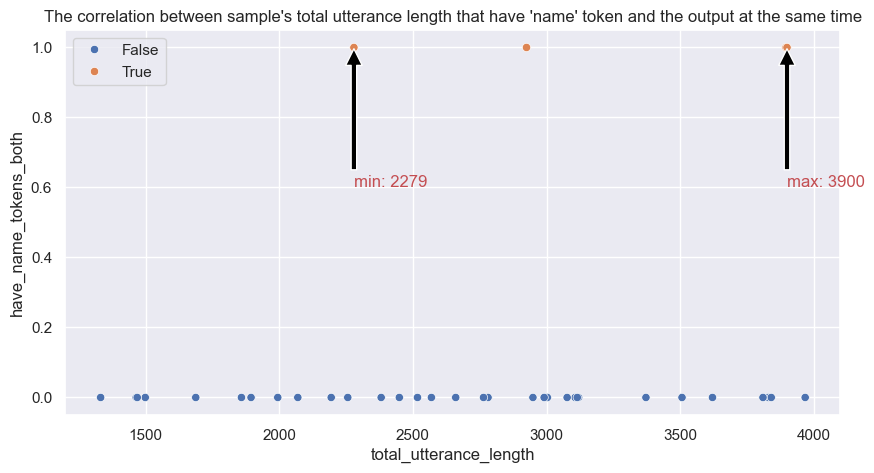

In [201]:
name_token_analysis(dev_df)

In [144]:
name_token_analysis(test_df, test=True)

The number of samples that have 'name' token: 112 / 408
The number of samples that have 'name+int' token in the utterance : 77 / 408
The number of samples that have only 'name' token in the utterance : 23 / 408
--------------------------------------------------


The number of samples that have 'name' token: 112 / 408
The number of samples that have 'name+int' token in the utterance : 77 / 408
The number of samples that have only 'name' token in the utterance : 23 / 408
The number of samples that have 'name' token in the output: 5 / 408
The number of samples that have 'name' token in the utterance and the output: 5 / 408
--------------------------------------------------


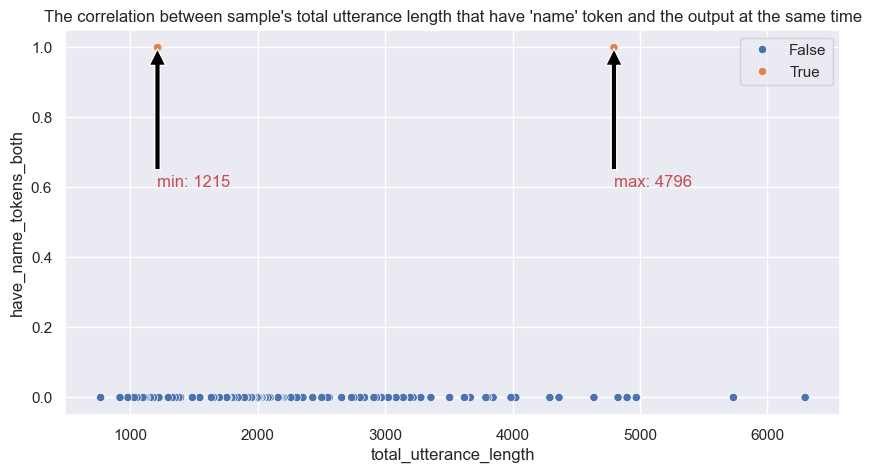

In [166]:
name_token_analysis(result_df)

The number of samples that have 'name' token: 112 / 408
The number of samples that have 'name+int' token in the utterance : 76 / 408
The number of samples that have only 'name' token in the utterance : 23 / 408
The number of samples that have 'name' token in the output: 3 / 408
The number of samples that have 'name' token in the utterance and the output: 3 / 408
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 3 / 112
The number of samples that have 'name' token in the utterance but not in the output: 109 / 112


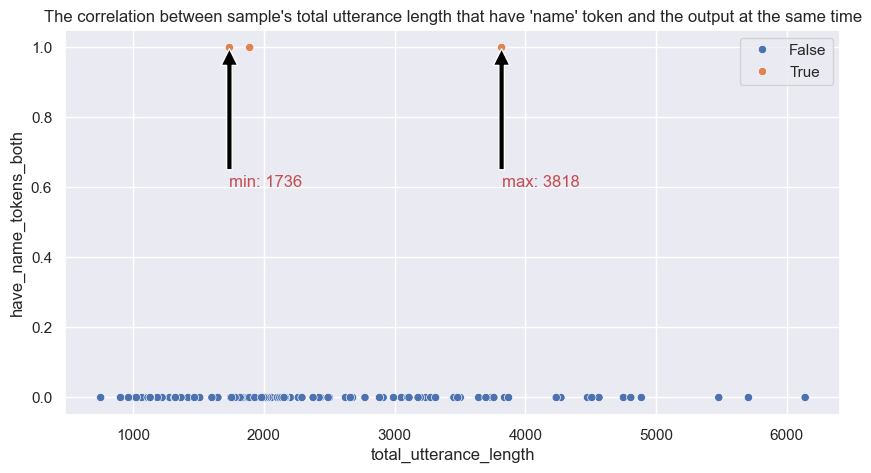

In [207]:
name_token_analysis(result_df)

The number of samples that have 'name' token: 112 / 408
The number of samples that have 'name+int' token in the utterance : 77 / 408
The number of samples that have only 'name' token in the utterance : 23 / 408
The number of samples that have 'name' token in the output: 5 / 408
The number of samples that have 'name' token in the utterance and the output: 5 / 408
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 5 / 112
The number of samples that have 'name' token in the utterance but not in the output: 107 / 112


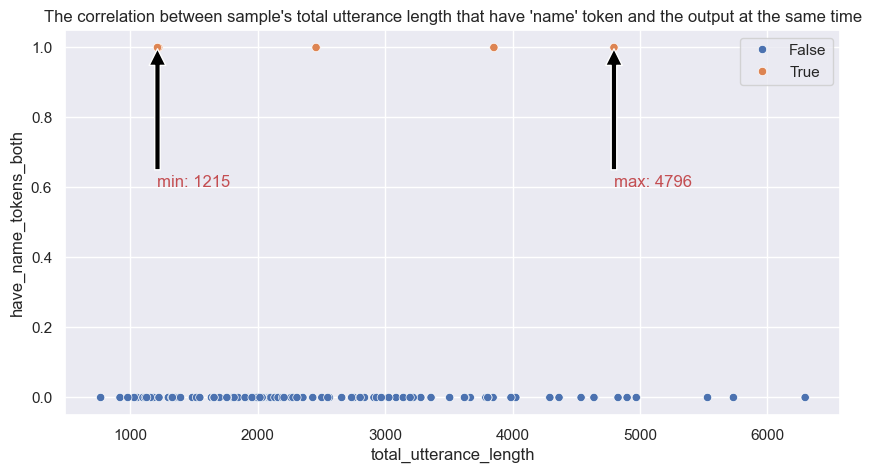

In [208]:
name_token_analysis(result2_df)

The number of samples that have 'name' token: 112 / 408
The number of samples that have 'name+int' token in the utterance : 77 / 408
The number of samples that have only 'name' token in the utterance : 23 / 408
The number of samples that have 'name' token in the output: 3 / 408
The number of samples that have 'name' token in the utterance and the output: 3 / 408
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 3 / 112
The number of samples that have 'name' token in the utterance but not in the output: 109 / 112


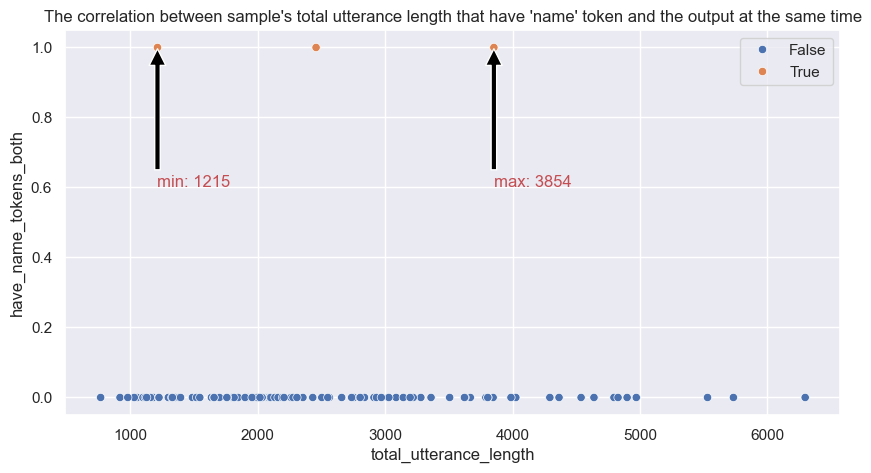

In [210]:
name_token_analysis(result3_df)

## 영어 token eda

- 영어로된 토큰은 무엇이 있고 얼마나 존재하는지

    - 무엇이 있는가?

In [237]:
def detect_english_tokens(df: pd.DataFrame) -> None:
    """
    Detect the English tokens in the utterances.

    Parameters:
    df (pd.DataFrame): DataFrame of the json file.
    """
    input_english_tokens= set()
    output_english_tokens = set()

    def detect_and_append(conv, for_output=False):
      detect = False
      if for_output:
        if re.findall(r'\S*[A-Za-z]+\S*', conv):
            for en_token in re.findall(r'\S*[A-Za-z]+\S* \S*', conv):
                if not re.match(r'\d*SD\d*', en_token):
                  output_english_tokens.add(en_token)
                  detect = True
        return detect
      
      for turn in conv:
            en_tokens = re.findall(r'\S*[A-Za-z]+\S* \S*', turn['utterance'])
            if en_tokens:
                 for en_token in en_tokens:
                    input_english_tokens.add(en_token)
                 detect = True

      return detect
    
    # The number of samples that have English tokens in the utterance
    have_english_tokens = df['conversation'].apply(detect_and_append)
    print(f"The number of samples that have English tokens: {have_english_tokens.sum()}",'/',
          f"{len(df)}")
    # print("indexes : ",have_english_tokens.index[have_english_tokens == True])
    print('--'*30)
    
    # The number of samples that have English tokens in the output
    have_english_tokens_output = df['output'].apply(lambda x: detect_and_append(x, for_output=True))
    print(f"The number of samples that have English tokens in the output: {have_english_tokens_output.sum()}",'/',
          f"{len(df)}")
    # print("indexes : ",have_english_tokens_output.index[have_english_tokens_output == True])
    print('--'*30)
    
    # The number of samples that have English tokens in the utterance and output at the same time 
    have_english_tokens_both = have_english_tokens & have_english_tokens_output
    print(f"The number of samples that have English tokens in the utterance and output at the same time: {have_english_tokens_both.sum()}",'/',
          f"{len(df)}")
    # print("indexes : ",have_english_tokens_both.index[have_english_tokens_both == True])


    return input_english_tokens, output_english_tokens

In [238]:
input_tokens, output_tokens = detect_english_tokens(train_df)

The number of samples that have English tokens: 228 / 506
------------------------------------------------------------
The number of samples that have English tokens in the output: 42 / 506
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 27 / 506


In [213]:
input_tokens, output_tokens = detect_english_tokens(train_df)

The number of samples that have English tokens: 231 / 506
------------------------------------------------------------
The number of samples that have English tokens in the output: 43 / 506
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 27 / 506


In [239]:
input_tokens

{'&address&1에 가면은',
 '&address&2 재개발하는',
 'XX대 이전부터',
 'company-name 가는',
 'company-name 갔을',
 'company-name 다닐',
 'company-name 라고',
 'company-name 상암동에',
 'company-name 얘기',
 'company-name1 company-name1',
 'company-name1 같은',
 'company-name1 그',
 'company-name1 세트가',
 'company-name1 세트인가?',
 'company-name1 아',
 'company-name10도 엄청',
 'company-name10이 가장',
 'company-name11 같은',
 'company-name11 되게',
 'company-name11 보다',
 'company-name11 진짜',
 'company-name11도 괜찮지.',
 'company-name11이 진짜',
 'company-name12 북해도식',
 'company-name12가 본점은',
 'company-name12도 보고',
 'company-name12도 사실',
 'company-name12도 있네?',
 'company-name12랑 이런',
 'company-name13 같은',
 'company-name13 둘',
 'company-name13은 사람',
 'company-name14인가? 하여튼',
 'company-name15 인가',
 'company-name16 인가?',
 'company-name17 가서',
 'company-name17 거기',
 'company-name17 그때',
 'company-name17 또',
 'company-name17도 가고',
 'company-name17를 여름에',
 'company-name1가 가지고',
 'company-name1에 그',
 'company-name1이 6개월은',
 'company-name1이 그',
 '

In [214]:
input_tokens

{'&address&1에',
 '&address&2',
 'XX대',
 'company-name',
 'company-name1',
 'company-name10도',
 'company-name10이',
 'company-name11',
 'company-name11도',
 'company-name11이',
 'company-name12',
 'company-name12가',
 'company-name12도',
 'company-name12랑',
 'company-name13',
 'company-name13은',
 'company-name14은',
 'company-name14인가?',
 'company-name15',
 'company-name16',
 'company-name16에서?',
 'company-name17',
 'company-name17도',
 'company-name17를',
 'company-name1가',
 'company-name1에',
 'company-name1이',
 'company-name1이라고',
 'company-name2',
 'company-name2가',
 'company-name2라고',
 'company-name2라는',
 'company-name2이라고',
 'company-name3',
 'company-name3가',
 'company-name3라고',
 'company-name3라는',
 'company-name4',
 'company-name4가',
 'company-name4도',
 'company-name4라는',
 'company-name4은',
 'company-name4을',
 'company-name4이',
 'company-name4인',
 'company-name4잖아.',
 'company-name5',
 'company-name5가',
 'company-name5는',
 'company-name5도',
 'company-name5라고',
 'company-name5랑',
 'compan

In [240]:
output_tokens

{'\x08SD2100543은 아직은',
 '3D 업종까지',
 '7kg 뺀',
 'AB형 혈액형을',
 'AB형에 대한',
 'AB형이고 혈액형',
 'AB형처럼 보여지고',
 'AI 면접과',
 'AI 면접에',
 'AI 면접은',
 'AI 면접을',
 'A형에 대한',
 'A형의 특성이',
 'C와 비타민',
 'D를 먹고',
 'ENFP와 본인의',
 'ENTJ가 되고',
 'ENTP로 나왔다고',
 'ISTJ인 친구와',
 'J가 되고',
 'J의 차이가',
 'K팝 댄스',
 'MBTI에서는 INFP로,',
 'N과 현실',
 'OTT 플랫폼과',
 'O형이고 AB형이',
 'O형이며 사람들과',
 'PD가 만든',
 'PT를 했다고',
 'P와 계획적인',
 'SF 기술력이',
 'SF, 드라마',
 'SSD2000873은 부모님',
 'SSD2001431은 상대방이',
 'S의 차이가',
 'TV 프로그램과',
 'TV 프로그램에서',
 'TV로 본다고',
 'T와 F는',
 'company-name1 세트가',
 'company-name1에 그',
 'company-name1을 보면',
 'company-name1이 곱창',
 'company-name1이 하는',
 'company-name2는 일본',
 'company-name2이 아르바이트를',
 'company-name2이라고 진짜',
 'company-name3은 저렴한',
 'company-name3은 홍보가',
 'company-name4가 작명',
 'company-name4도 괜찮다고',
 'company-name4에 가서',
 'company-name4이 신라',
 'company-name5가 더',
 'company-name5는 노량진에서',
 'company-name5는 소고기',
 'company-name5는 한',
 'company-name5를 보면서',
 'company-name5를 여러',
 'company-name5에 12만',
 'company-name5에서 가장'

In [220]:
input_tokens, output_tokens = detect_english_tokens(dev_df)

The number of samples that have English tokens: 58 / 102
------------------------------------------------------------
The number of samples that have English tokens in the output: 13 / 102
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 8 / 102


In [223]:
input_tokens

{'name',
 'name1',
 'name10',
 'name1가',
 'name1는',
 'name1님은',
 'name1랑',
 'name1야.',
 'name1이',
 'name1이가',
 'name1이는',
 'name1하고',
 'name2',
 'name2가',
 'name2는',
 'name2는?',
 'name2도.',
 'name2라는',
 'name2랑',
 'name2아',
 'name2은',
 'name2은.',
 'name2이',
 'name2이는',
 'name3',
 'name3랑',
 'name3은',
 'name3이',
 'name3이가',
 'name3이도',
 'name3한테',
 'name4',
 'name4.',
 'name4라고',
 'name4이',
 'name4이도',
 'name4한테',
 'name5',
 'name6',
 'name7',
 'name8',
 'name9',
 'name가',
 'name나',
 'name는',
 'name랑',
 'name를',
 'name씨',
 'name씨는',
 'name씨를',
 'name아.',
 'name이',
 'name이가',
 'name이는',
 'name이도',
 'name이랑은',
 'name이를',
 'x',
 'xx',
 'xxx',
 'xxx까',
 'xxx씀',
 'xx까',
 'xx니까는',
 'xx법까지다',
 'xx서',
 'x가',
 'x걸',
 'x까',
 'x냥',
 'x니까',
 'x단',
 'x데',
 'x번',
 'x양',
 'x정',
 'x제',
 '같x',
 '같xx',
 '공동체xx',
 '괜찮x데',
 '그x',
 '그xx',
 '그래x',
 '그렇x',
 '그리x',
 '나오더라xx.',
 '당x하다고',
 '됐을x',
 '씹x',
 '어name2이',
 '옛x',
 '웬x',
 '이x',
 '이케x',
 '주장이였x',
 '하더래x'}

In [224]:
output_tokens

{'BTS,',
 'F를',
 'SSD2000851은',
 'TV',
 'TV에',
 'name1과',
 'name1의',
 'name1이',
 'name과',
 'name의',
 'name이',
 '말했습니다.SD2000850은',
 '비타민C',
 '비타민D와',
 '했습니다.SD2000864는',
 '했습니다.SD2000868은'}

In [227]:
input_tokens, output_tokens = detect_english_tokens(test_df)

The number of samples that have English tokens: 178 / 408
------------------------------------------------------------
The number of samples that have English tokens in the output: 0 / 408
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 0 / 408


In [228]:
input_tokens

{'&address&에',
 '&company-name&',
 '&company-name&1라고',
 '&company-name&2가',
 '&company-name&2였는데',
 '&company-name&?',
 '&company-name&가',
 '&company-name&라고',
 '&company-name&은',
 '&company-name&의',
 '&company-name&이라는',
 'n1',
 'name',
 'name1',
 'name1가',
 'name1는',
 'name1님은',
 'name1도',
 'name1라',
 'name1랑',
 'name1를',
 'name1은',
 'name1이',
 'name1이가',
 'name1이도',
 'name1이랑',
 'name1하고',
 'name1한테.',
 'name2',
 'name2가',
 'name2는',
 'name2라는',
 'name2랑',
 'name2아',
 'name2이',
 'name2이는',
 'name2이도',
 'name2이라는',
 'name2이랑',
 'name2이를',
 'name2인가?',
 'name3',
 'name3가',
 'name3나',
 'name3랑',
 'name3은',
 'name3이라는',
 'name3이랑',
 'name3하고',
 'name4',
 'name4가',
 'name4나',
 'name4라는',
 'name4랑',
 'name4이',
 'name4이잖아.',
 'name4하고',
 'name5',
 'name5가',
 'name5는',
 'name5라는',
 'name5란',
 'name5랑',
 'name5이다아이가',
 'name5이랑',
 'name6',
 'name6가',
 'name7랑',
 'name는',
 'name아',
 'name야',
 'name이',
 'name이가',
 'x',
 'xx',
 'xxx',
 'xxxx',
 'xxxxx습니다.',
 'xx게',
 'xx까',
 'xx도',
 'xx로',
 'xx

In [245]:
input_tokens, output_tokens = detect_english_tokens(result_df)

The number of samples that have English tokens: 174 / 408
------------------------------------------------------------
The number of samples that have English tokens in the output: 9 / 408
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 3 / 408


In [246]:
output_tokens

{'&company-name &',
 'D와 칼슘에',
 'IMF가 터져서',
 'K와 같은',
 'SNS에서 반려동물을',
 'TV 프로그램에',
 'name2님도 한',
 'name4와 사귀게',
 'name5가 소개해준',
 '에스에스비(S.S.B) 동아리에서'}

### name 토큰의 존재 통계

- 'name' 토큰이 존재하는 샘플 수


- 'name' 토큰 유형
    - 유형별 통계


- 'name' 토큰 유형별 전처리

## 온점 뒤에 공백이 존재하지 않는 샘플
- 현재 tokenizer에는 공백이 token으로 사용되고 있다.
    - 뿐만 아니라, 공백이 몇 개가 연속되어 붙어있는지에 따라 서로 다른 token을 사용한다
    - 그러므로, 공백을 어떻게 사용하는지가 문장 생성에 영향을 끼칠 가능성이 있다.